In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

In [2]:
from medmnist import DermaMNIST, RetinaMNIST, OCTMNIST

In [3]:
import torch
import torchvision.transforms as tr
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [4]:
if torch.cuda.is_available():
    print('using the GPU')
    device = 'cuda'
else: 
    print('using the CPU')
    device='cpu'

using the GPU


In [5]:
def set_seed(seed_value):
    if seed_value is not None:
        np.random.seed(seed_value)  # cpu vars
        torch.manual_seed(seed_value)  # cpu  vars
        random.seed(seed_value)  # Python
        # torch.use_deterministic_algorithms(True)

        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed_value)
            torch.cuda.manual_seed_all(seed_value)
            torch.backends.cudnn.deterministic = True
set_seed(0)

### Data
In this hands-on session we will be playing with `medMNIST`, a collection of datasets similar to MNIST but with medical images. For training, we will be using OCT images from the `OCT` subdataset in `medMNIST`.

In [6]:
dataset = 'OCT'

In [7]:
# preprocessing - to-tensor and normalize using imagenet stats
transforms = tr.Compose([tr.ToTensor(), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# datasets
if dataset == 'DERMA':
    train_dataset = DermaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = DermaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = DermaMNIST(split='test', transform=transforms, download=True)
elif dataset == 'RETINA':
    train_dataset = RetinaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = RetinaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = RetinaMNIST(split='test', transform=transforms, download=True)
elif dataset == 'OCT':
    train_dataset = OCTMNIST(split='train', transform=transforms, download=True, as_rgb=True)
    val_dataset   = OCTMNIST(split='val', transform=transforms, download=True, as_rgb=True)
    test_dataset  = OCTMNIST(split='test', transform=transforms, download=True, as_rgb=True)
else:
    print('please choose between dataset=\'DERMA\', dataset=\'RETINA\' or dataset=\'OCT\'')

# dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=256, shuffle=False)

Using downloaded and verified file: /home/u109509/.medmnist/octmnist.npz
Using downloaded and verified file: /home/u109509/.medmnist/octmnist.npz
Using downloaded and verified file: /home/u109509/.medmnist/octmnist.npz


In [8]:
len(train_dataset), len(val_dataset), len(test_dataset)

(97477, 10832, 1000)

Let us have a look at the data, it cannot hurt.

In [9]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([33484, 10213,  7754, 46026]))

In [10]:
n_classes = len(np.unique(train_dataset.labels))

n_epochs, lr = 20, 1e-4 # 20 is enough for this dataset, I can see the future

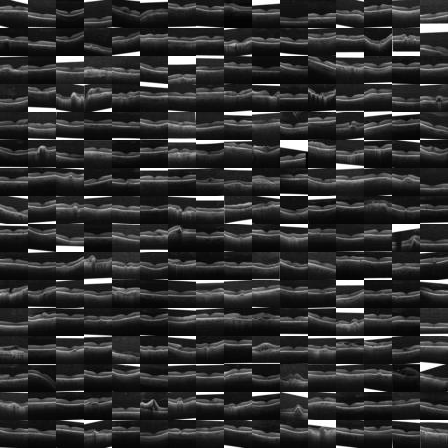

In [11]:
train_dataset.montage(length=16)

### Model Training
The next cell defines a standard training loop in pytorch:

In [12]:
def run_one_epoch(loader, model, criterion, optimizer=None):

    device='cuda' if next(model.parameters()).is_cuda else 'cpu'
    train = optimizer is not None  # if we are in training mode, there will be an optimizer and train=True here

    if train: model.train()
    else: model.eval()
    probs_all, preds_all, labels_all = [], [], []
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        logits = model(inputs)
        loss = criterion(logits, labels)

        if train:  # only in training mode
            loss.backward()
            optimizer.step()

        probs = logits.softmax(dim=1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)
        labels = labels.cpu().numpy()

        probs_all.extend(probs)
        preds_all.extend(preds)
        labels_all.extend(labels)
            
    return np.stack(preds_all), np.stack(probs_all), np.stack(labels_all)

As usual, we will be needing a model, an optimizer, and a criterion. Let us now train a `resnet18` to classify this dataset:

In [13]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, out_features=n_classes)
model.to(device);

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Now, either you train a model below (<10 minutes on a small laptop gpu) or you load weights I already trained myself, and save some time.

#### If you want to load the model weights:

In [14]:
model.load_state_dict(torch.load('r18_oct_weights.pth'));

#### If you want to train the model:
Let us train `model` and then analyze predictions. We monitor AUC on the training and the validation set to detect overfitting.

In [16]:
for epoch in tqdm(range(n_epochs)):
    _,  _, _ = run_one_epoch(train_loader, model, criterion, optimizer)
    with torch.inference_mode():
        tr_preds, tr_probs, tr_labels = run_one_epoch(train_loader, model, criterion)
        vl_preds, vl_probs, vl_labels = run_one_epoch(val_loader, model, criterion)

        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class='ovr')
        vl_auc = roc_auc_score(vl_labels, vl_probs, multi_class='ovr')
        print('Epoch {}, TR/VL AUC={:.2f}/{:.2f}'.format(epoch+1, 100*tr_auc, 100*vl_auc))
torch.save(model.state_dict(), 'r18_oct_weights.pth');

  5%|██▏                                         | 1/20 [00:24<07:45, 24.48s/it]

Epoch 1, TR/VL AUC=91.35/91.33


 10%|████▍                                       | 2/20 [00:45<06:46, 22.57s/it]

Epoch 2, TR/VL AUC=92.86/92.80


 15%|██████▌                                     | 3/20 [01:07<06:13, 22.00s/it]

Epoch 3, TR/VL AUC=93.29/93.09


 20%|████████▊                                   | 4/20 [01:28<05:47, 21.71s/it]

Epoch 4, TR/VL AUC=94.00/93.94


 25%|███████████                                 | 5/20 [01:49<05:22, 21.51s/it]

Epoch 5, TR/VL AUC=94.45/94.13


 30%|█████████████▏                              | 6/20 [02:10<05:00, 21.46s/it]

Epoch 6, TR/VL AUC=94.67/94.37


 35%|███████████████▍                            | 7/20 [02:32<04:38, 21.39s/it]

Epoch 7, TR/VL AUC=94.71/94.45


 40%|█████████████████▌                          | 8/20 [02:53<04:16, 21.35s/it]

Epoch 8, TR/VL AUC=94.37/94.13


 45%|███████████████████▊                        | 9/20 [03:14<03:54, 21.36s/it]

Epoch 9, TR/VL AUC=93.30/93.12


 50%|█████████████████████▌                     | 10/20 [03:36<03:33, 21.36s/it]

Epoch 10, TR/VL AUC=95.24/94.95


 55%|███████████████████████▋                   | 11/20 [03:57<03:11, 21.33s/it]

Epoch 11, TR/VL AUC=95.37/95.03


 60%|█████████████████████████▊                 | 12/20 [04:19<02:51, 21.45s/it]

Epoch 12, TR/VL AUC=95.20/94.83


 65%|███████████████████████████▉               | 13/20 [04:40<02:29, 21.42s/it]

Epoch 13, TR/VL AUC=95.58/95.20


 70%|██████████████████████████████             | 14/20 [05:01<02:08, 21.43s/it]

Epoch 14, TR/VL AUC=95.75/95.31


 75%|████████████████████████████████▎          | 15/20 [05:23<01:47, 21.46s/it]

Epoch 15, TR/VL AUC=95.73/95.31


 80%|██████████████████████████████████▍        | 16/20 [05:44<01:25, 21.48s/it]

Epoch 16, TR/VL AUC=95.78/95.31


 85%|████████████████████████████████████▌      | 17/20 [06:06<01:04, 21.52s/it]

Epoch 17, TR/VL AUC=95.98/95.43


 90%|██████████████████████████████████████▋    | 18/20 [06:28<00:43, 21.54s/it]

Epoch 18, TR/VL AUC=96.09/95.55


 95%|████████████████████████████████████████▊  | 19/20 [06:49<00:21, 21.57s/it]

Epoch 19, TR/VL AUC=96.16/95.66


100%|███████████████████████████████████████████| 20/20 [07:11<00:00, 21.57s/it]

Epoch 20, TR/VL AUC=96.11/95.71


### Move on

In [15]:
y_pred_test, y_probs_test, y_test = run_one_epoch(test_loader, model, criterion)

In [16]:
train_dataset.info['label']

{'0': 'choroidal neovascularization',
 '1': 'diabetic macular edema',
 '2': 'drusen',
 '3': 'normal'}

In [17]:
classes = [train_dataset.info['label'][str(c)][:4]+'.' for c in range(n_classes)]
classes

['chor.', 'diab.', 'drus.', 'norm.']

In [18]:
print("Accuracy: {:.2f}%".format(100*(y_pred_test == y_test).mean()))
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(pd.DataFrame(cm, index=classes, columns=classes))

Accuracy: 69.30%
       chor.  diab.  drus.  norm.
chor.    236     13      0      1
diab.     38    200      2     10
drus.    122      9     28     91
norm.      6     11      4    229


In this confusion matrix, rows indicate the true classes and columns the predicted classes. For example, 9 drusen-affected images were wrongly classified as diabetic macular edema.

The classes seem to have different classification diﬀiculties, for example drusen images are very often classified incorrectly as choroidal neovascularization or normal.

In [19]:
# https://stackoverflow.com/a/65673016
accuracies = {name: 100*accuracy_score(np.array(y_test) == i, np.array(y_pred_test) == i) for i, name in enumerate(classes)}
for (key, acc) in accuracies.items():
    print('Class {}, acc = {:.2f}%'.format(key, acc))

Class chor., acc = 82.00%
Class diab., acc = 91.70%
Class drus., acc = 77.20%
Class norm., acc = 87.70%


Not the best model. How can we deal with uncertainty in this case? Imagine we relax our requirements, and we are allowed to return more than one category, so we will return **Prediction Sets**. 

In exchange of this relaxation, we acquire the compromise of returning, for example, 95% of the times the correct category among the classes we return. This is called **Coverage**.

First thing we will try is to leverage the predicted probability score. **If the model is calibrated**, then an item predicted with 95% confidence should be 95% of the times correctly predicted. Therefore, we will do as follows: if a category is predicted with 95% confidence or more, then we will return it, otherwise not. 

* You may ask: what do we do with images that have no category predicted with 95% confidence? We will see later.

* You may also ask: if we are requiring 95% confidence, there might only be 0 or 1 categories in our set of returned predictions. That is correct, but if we were asking for 40% confidence, then we could also have 2 categories, etc.

In [20]:
# Get for each instance the highest probability (confidence)
confidences = np.amax(y_probs_test, axis=1)

# Select the predictions where probability over 95%
p = 0.95
confident_predictions = np.where(confidences >= p)[0]

The fraction of examples for which we are not abstaining is called coverage:

In [21]:
we_will_return = len(confident_predictions)
total = len(y_probs_test)
coverage = 100*we_will_return/total
print('Coverage @ >{:.2f} = {:.2f}%'.format(p, coverage))

Coverage @ >0.95 = 44.50%


So out of 1000 predictions, we are keeping 445. Now we hope that within that subset, we will have 95% accuracy.

In [22]:
a = (y_pred_test[confident_predictions]==y_test[confident_predictions]).mean()
print('Accuracy @ >{:.2f} = {:.2f}'.format(p, 100*a))

Accuracy @ >0.95 = 92.81


Not far from 95%, which means the model was relatively well calibrated.

Note that, as we reduce our confidence threshold, we increase coverage, but we most likely will sacrifice accuracy:

In [23]:
# Select the predictions where probability over 40%
p = 0.40
confident_predictions = np.where(confidences >= p)[0]
we_will_return = len(confident_predictions)
total = len(y_probs_test)
coverage = 100*we_will_return/total

a = (y_pred_test[confident_predictions]==y_test[confident_predictions]).mean()

print('Coverage @ >{:.2f} = {:.2f}%'.format(p, coverage))
print('Accuracy @ >{:.2f} = {:.2f}'.format(p, 100*a))

Coverage @ >0.40 = 98.00%
Accuracy @ >0.40 = 70.31


So this is the thing: as we increase coverage we include less confident predictions, which tend to be more erroneous (unless the model is completely miscalibrated). In fact, if the model was perfectly calibrated, coverage and accuracy would be absolutely aligned for all levels of confidence. But since most models are often not calibrated, we need another approach here.

Instead of asking ourselves what can we do to guarantee a coverage of 95%, looks like we need to lower our confidence threshold until we reach a desired level of coverage. But if we lower the threshold, more categories might slip into our predictions, right? Instead of becoming frustrated, we will embrace that fact!

### Conformal Prediction in action:
We will work with a calibration set extracted from test data to find a threshold that guarantees 95% coverage.

In [24]:
print(y_pred_test.shape, y_probs_test.shape, y_test.shape)
y_pred_calib, y_pred_test = y_pred_test[:500], y_pred_test[500:]
y_probs_calib, y_probs_test = y_probs_test[:500,], y_probs_test[500:,]
y_calib, y_test = y_test[:500], y_test[500:]
print(y_pred_test.shape, y_probs_test.shape, y_test.shape)

(1000,) (1000, 4) (1000,)
(500,) (500, 4) (500,)


In [25]:
# Size of calibration data
n = len(y_calib)
# We only need the probability for the true class
prob_true_class_calib = y_probs_calib[np.arange(n),y_calib]
# Turn into uncertainty score (larger means more uncertain)
scores_calib = 1 - prob_true_class_calib

In [26]:
y_probs_calib[0], y_calib[0], prob_true_class_calib[0], scores_calib[0] # all good

(array([0.00826297, 0.00889152, 0.04557854, 0.937267  ], dtype=float32),
 3,
 0.937267,
 0.062732995)

In [27]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat_calib = np.quantile(scores_calib, q_level, method='higher')
qhat_calib

0.9639752

In [28]:
prediction_sets_calib = (1 - y_probs_calib <= qhat_calib)
prediction_sets_calib[0]

array([False, False,  True,  True])

In [29]:
for i in range(3):
    pred_set = prediction_sets_calib[i]
    print([classes[c] for c in range(len(classes)) if pred_set[c]])

['drus.', 'norm.']
['chor.', 'drus.', 'norm.']
['norm.']


Let us see coverage:

In [30]:
# https://stackoverflow.com/a/23435843
is_true_class_present = prediction_sets_calib[np.arange(len(prediction_sets_calib)), y_calib]
coverage_calib = is_true_class_present.sum()/len(is_true_class_present)
print('Coverage @ >{:.2f} = {:.2f}%'.format(alpha, 100*coverage_calib))

Coverage @ >0.05 = 95.40%


This was our guarantee for the calibration set, which is fulfilled by construction. Let us now see if it translates to the test set:

In [31]:
# Size of calibration data
n = len(y_test)
# We only need the probability for the true class
prob_true_class_test = y_probs_test[np.arange(n),y_test]
# Turn into uncertainty score (larger means more uncertain)
scores_test = 1 - prob_true_class_test

In [32]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat_test = np.quantile(scores_test, q_level, method='higher')
qhat_test

0.95382625

In [33]:
prediction_sets_test = (1 - y_probs_test <= qhat_test)
prediction_sets_test[0]

array([False,  True, False,  True])

In [34]:
# https://stackoverflow.com/a/23435843
is_true_class_present = prediction_sets_test[np.arange(len(prediction_sets_test)), y_test]
coverage_test = is_true_class_present.sum()/len(is_true_class_present)
print('Coverage @ >{:.2f} = {:.2f}%'.format(alpha, 100*coverage_test))

Coverage @ >0.05 = 95.40%


Great!!

## Real world scenario - so that you don't get too thrilled about Conformal Prediction yet:
In real life, you would not have a perfectly i.i.d. calibration/test pair, like the one we created by splitting the original test set in two halves. What I would have done would have been to use the original validation set we used for early stopping as calibration set, but it turns out this is not representative of the test set, see:

In [35]:
y_pred_val, y_probs_val, y_val = run_one_epoch(val_loader, model, criterion)
y_pred_test, y_probs_test, y_test = run_one_epoch(test_loader, model, criterion)

In [36]:
print("Validation Set Accuracy: {:.2f}%".format(100*(y_pred_val == y_val).mean()))
# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
print(pd.DataFrame(cm, index=classes, columns=classes))

Validation Set Accuracy: 88.52%
       chor.  diab.  drus.  norm.
chor.   3545     61     56     59
diab.     85    944     14     92
drus.    207     34    236    385
norm.     50    109     92   4863


In [37]:
print("Test Set Accuracy: {:.2f}%".format(100*(y_pred_test == y_test).mean()))
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(pd.DataFrame(cm, index=classes, columns=classes))

Test Set Accuracy: 69.30%
       chor.  diab.  drus.  norm.
chor.    236     13      0      1
diab.     38    200      2     10
drus.    122      9     28     91
norm.      6     11      4    229


(Note that on the [medmnist benchmark](https://medmnist.com/) they have an accuracy of `acc=76.3` on this dataset, so this is not too off)

So the validation set is actually quite easier to predict. If we now find our threshold here, we will not get the guaranteed coverage we would be expecting:

In [38]:
# Size of calibration data
n = len(y_val)
# We only need the probability for the true class
prob_true_class_val = y_probs_val[np.arange(n),y_val]
# Turn into uncertainty score (larger means more uncertain)
scores_val = 1 - prob_true_class_val

In [39]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat_val = np.quantile(scores_val, q_level, method='higher')
qhat_val

0.8335277

In [40]:
prediction_sets_val = (1 - y_probs_val <= qhat_val)
prediction_sets_val[0]

array([False, False, False,  True])

So in both datasets we have a guaranteed coverage *when we use them to evaluate themselves*.

In [41]:
# https://stackoverflow.com/a/23435843
is_true_class_present = prediction_sets_val[np.arange(len(prediction_sets_val)), y_val]
coverage_val = is_true_class_present.sum()/len(is_true_class_present)

print('Validation Set Coverage @ >{:.2f} = {:.2f}%'.format(alpha, 100*coverage_val))
print('Test       Set Coverage @ >{:.2f} = {:.2f}%'.format(alpha, 100*coverage_test))

Validation Set Coverage @ >0.05 = 95.02%
Test       Set Coverage @ >0.05 = 95.40%


But in reality we would have take `qhat_val` and used it on the test set like this:

In [42]:
prediction_sets_test = (1 - y_probs_test <= qhat_val)

In [43]:
# https://stackoverflow.com/a/23435843
is_true_class_present = prediction_sets_test[np.arange(len(prediction_sets_test)), y_test]
coverage_test = is_true_class_present.sum()/len(is_true_class_present)

print('Test       Set Coverage @ >{:.2f} = {:.2f}%'.format(alpha, 100*coverage_test))

Test       Set Coverage @ >0.05 = 83.00%


Ta-daaaaa. This is an example of what happens if we violate the exchangeability assumption in Conformal Prediction.